In [11]:
# Importing req libraries
import os
import mlflow
import logging
import dagshub
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import pyarrow.csv as pv
import pyarrow.parquet as pq
import pyarrow.compute as pc

# Importing required modules from sklearn library
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, confusion_matrix, f1_score

# Importing harmless warninga
import warnings
warnings.filterwarnings('ignore')

# Notebook formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [32]:
# Importing training transaction data

csv_file = "train_transaction.csv"
parquet_file = "train_transaction.parquet"

table = pv.open_csv(csv_file)
pq.write_table(table.read_all(), parquet_file)


# Checking sample data
train_tr = pd.read_parquet("train_transaction.parquet")
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,,,,M0,T,T,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,

In [33]:
# True disk compression

csv_size = os.path.getsize("train_transaction.csv") / (1024**2)
print(f"CSV size: {csv_size:.2f} MB")

parquet_size = os.path.getsize("train_transaction.parquet") / (1024**2)
print(f"Parquet size: {parquet_size:.2f} MB")

CSV size: 651.69 MB
Parquet size: 72.32 MB


In [34]:
# Training transaction data shape

train_tr.shape

(590540, 394)

In [35]:
# Importing training identity data

csv_file = "train_identity.csv"
parquet_file = "train_identity.parquet"

table = pv.open_csv(csv_file)
pq.write_table(table.read_all(), parquet_file)


# Checking sample data
train_id = pd.read_parquet("train_identity.parquet")
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,,NaN,NaN,NaN,,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,,NaN,NaN,NaN,,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,,NaN,NaN,NaN,,Found,Found,,chrome 62.0,NaN,,,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,,NaN,NaN,NaN,,New,NotFound,,chrome 62.0,NaN,,,F,F,T,T,desktop,
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,,NaN,NaN,NaN,,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [36]:
# True disk compression

csv_size = os.path.getsize("train_identity.csv") / (1024**2)
print(f"CSV size: {csv_size:.2f} MB")

parquet_size = os.path.getsize("train_identity.parquet") / (1024**2)
print(f"Parquet size: {parquet_size:.2f} MB")

CSV size: 25.30 MB
Parquet size: 3.71 MB


In [37]:
# Training identity data shape

train_id.shape

(144233, 41)

In [38]:
# Left join on TransactionID
train_merged = train_tr.merge(train_id,on="TransactionID",how="left")

print(train_merged.shape)

(590540, 434)


In [39]:
# Training data sample

train_merged.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,,,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0

In [40]:
# Data validation

# train_mergedframe for missing value & train_mergedtype
msg_train_merged = pd.DataFrame({'Missing Values Percentage' : round(train_merged.isnull().mean()*100,2), 'train_merged Type' : train_merged.dtypes})

# train_mergedframe for 2 samples
sample = train_merged.head(2).T

# Concating msg_train_merged and sample
msg_train_merged_sample = pd.concat([msg_train_merged, sample], axis = 1)

# Renaming columns
msg_train_merged_sample.rename(columns = {0: 'Sample_1', 1: 'Sample_2'}, inplace = True)

# Missing train_merged sample
msg_train_merged_sample

,Missing Values Percentage,train_merged Type,Sample_1,Sample_2
TransactionID,0.00,int64,2987000,2987001
isFraud,0.00,int64,0,0
TransactionDT,0.00,int64,86400,86401
TransactionAmt,0.00,float64,68.5,29.0
ProductCD,0.00,object,W,W
card1,0.00,int64,13926,2755
card2,1.51,float64,NaN,404.0
card3,0.27,float64,150.0,150.0
card4,0.00,object,discover,mastercard
card5,0.72,float64,142.0,102.0


In [41]:
# Column duplicates check

# -------- Cheap existence check --------
def has_duplicate_columns(df, chunk_size=50_000):
    fingerprints = {col: 0 for col in df.columns}
    prime = 1315423911

    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start+chunk_size]

        for col in df.columns:
            fingerprints[col] = fingerprints[col] * prime + pd.util.hash_pandas_object(chunk[col], index=False).sum()

    return len(set(fingerprints.values())) != len(fingerprints)


# -------- Safe removal --------
def drop_duplicate_columns_safe(df, chunk_size=50_000):
    cols = df.columns
    fingerprints = {col: 0 for col in cols}
    prime = 1315423911

    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start+chunk_size]

        for col in cols:
            fingerprints[col] = fingerprints[col] * prime + pd.util.hash_pandas_object(chunk[col], index=False).sum()

    seen = {}
    keep_cols = []

    for col, fp in fingerprints.items():
        if fp not in seen:
            seen[fp] = col
            keep_cols.append(col)

    return df[keep_cols]

In [42]:
# Row duplicates check

# -------- Cheap existence check --------
def has_duplicate_rows(df, chunk_size=50_000):
    seen = set()
    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start+chunk_size]
        hashes = pd.util.hash_pandas_object(chunk, index=False)

        for h in hashes:
            if h in seen:
                return True
            seen.add(h)
    return False


# -------- Safe removal --------
def drop_duplicate_rows_safe(df, chunk_size=50_000):
    seen = set()
    kept_chunks = []

    for start in range(0, len(df), chunk_size):
        chunk = df.iloc[start:start+chunk_size]
        hashes = pd.util.hash_pandas_object(chunk, index=False)

        mask = []
        for h in hashes:
            if h in seen:
                mask.append(False)
            else:
                seen.add(h)
                mask.append(True)

        kept_chunks.append(chunk.loc[mask])

    return pd.concat(kept_chunks, ignore_index=True)

In [43]:
# Always columns first
if has_duplicate_columns(train_merged):
    print("Duplicate columns found. Removing…")
    train_merged = drop_duplicate_columns_safe(train_merged)
else:
    print("No duplicate columns.")

# Then rows
if has_duplicate_rows(train_merged):
    print("Duplicate rows found. Removing…")
    train_merged = drop_duplicate_rows_safe(train_merged)
else:
    print("No duplicate rows.")

No duplicate columns.
No duplicate rows.


In [44]:
# Checking Cat and Num Columns

cat_cols = [col for col in train_merged.columns if train_merged[col].dtype == 'O']
num_cols = [col for col in train_merged.columns if train_merged[col].dtype != 'O']

print(f'Categorical Columns: {cat_cols}')
print(f'\nNumerical Columns: {num_cols}')

Categorical Columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

Numerical Columns: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 

In [45]:
# Checking cols with single unique value
single_unique_cols = [col for col in train_merged.columns if train_merged[col].nunique() == 1]

if len(single_unique_cols)>0:
    print(f'Single Unique Columns:{single_unique_cols}')
else:
    print(f'The data has no single unique cols')

The data has no single unique cols


In [46]:
# Checking cols with more than 30% data missing

mv_grt_30 = [col for col in train_merged.columns if round(train_merged[col].isnull().mean()*100, 2)>30]

if len(mv_grt_30)>0:
    print(f'Columns with missing values greater than 30:{mv_grt_30} \nNo of columns: {len(mv_grt_30)}')
else:
    print(f'No column has greater than 30% data missing')

Columns with missing values greater than 30:['dist1', 'dist2', 'D2', 'D3', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237',

In [ ]:
mv_grt_30 = [col for col in train_merged.columns if round(train_merged[col].isnull().mean()*100, 2)>70]

if len(mv_grt_30)>0:
    print(f'Columns with missing values greater than 70:{mv_grt_30} \nNo of columns: {len(mv_grt_30)}')

Columns with missing values greater than 30:['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250

In [51]:
# Identifying true numeric columns

df = train_merged.copy()

numeric_cols = []
categorical_cols = []

for col in df.columns:
    if col == "isFraud":
        continue

    # Try converting to numeric
    coerced = pd.to_numeric(df[col], errors="coerce")

    # If most values convert to numbers → numeric
    non_null_ratio = coerced.notna().mean()

    if non_null_ratio > 0.8:   # 80% convertible = numeric signal
        df[col] = coerced
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

In [52]:
# Getting the true num and cat cols

print(f'True numeric cols : {numeric_cols}')
print(f'\nTrue category cols : {categorical_cols}')

True numeric cols : ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D10', 'D15', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V

In [53]:
# Enforce numeric purity
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Enforce categorical purity
for col in categorical_cols:
    df[col] = df[col].astype("string")

In [54]:
# Remove target and ID

numeric_cols.remove("TransactionID")
categorical_cols = [c for c in categorical_cols if c != "TransactionID"]

In [55]:
# Imputing correctly

# Numeric → -1
for col in numeric_cols:
    df[col].fillna(-1, inplace=True)

# Categorical → "unknown"
for col in categorical_cols:
    df[col].fillna("unknown", inplace=True)

In [56]:
# Safe downcasting (column by column)

# Downcast floats
for col in df.select_dtypes(include="float"):
    df[col] = pd.to_numeric(df[col], downcast="float")

# Downcast integers
for col in df.select_dtypes(include="integer"):
    df[col] = pd.to_numeric(df[col], downcast="integer")

In [57]:
# Convert categoricals to category

for col in df.select_dtypes(include="object"):
    if df[col].nunique() < 0.5 * len(df):
        df[col] = df[col].astype("category")

In [60]:
# Saving as paraquet

df.to_parquet(
    "final_df.parquet",
    engine="pyarrow",
    compression="zstd",
    index=False
)

In [6]:
print("Parquet file size:",
      os.path.getsize("final_df.parquet") / 1024**2, "MB")

Parquet file size: 64.9865255355835 MB


In [5]:
# Final dataframe

# Load Parquet via Arrow
table = pq.read_table("final_df.parquet")

# Save it back in pure Arrow format
pq.write_table(
    table,
    "final_df_clean.parquet",
    compression="zstd"
)

# Load with Arrow-backed Pandas
final_df = pd.read_parquet(
    "final_df_clean.parquet",
    dtype_backend="pyarrow"
)

In [ ]:
# Final df usage

final_df.memory_usage(deep=True).sum() / 1024**2

np.float64(1832.1006650924683)

In [11]:
# Final Data validation

# Dataframe for missing value & dftype
msg_df = pd.DataFrame({'Missing Values Percentage' : round(final_df.isnull().mean()*100,2), 'df Type' : final_df.dtypes})

# dfframe for 2 samples
sample = final_df.head(2).T

# Concating msg_df and sample
msg_df_sample = pd.concat([msg_df, sample], axis = 1)

# Renaming columns
msg_df_sample.rename(columns = {0: 'Sample_1', 1: 'Sample_2'}, inplace = True)

# Missing df sample
msg_df_sample

,Missing Values Percentage,df Type,Sample_1,Sample_2
TransactionID,0.0,int32[pyarrow],2987000,2987001
isFraud,0.0,int8[pyarrow],0,0
TransactionDT,0.0,int32[pyarrow],86400,86401
TransactionAmt,0.0,float[pyarrow],68.5,29.0
ProductCD,0.0,string[pyarrow],W,W
card1,0.0,int16[pyarrow],13926,2755
card2,0.0,float[pyarrow],-1.0,404.0
card3,0.0,float[pyarrow],150.0,150.0
card4,0.0,string[pyarrow],discover,mastercard
card5,0.0,float[pyarrow],142.0,102.0


In [12]:
# Target column analysis

final_df['isFraud'].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64[pyarrow]

### Observations

Here are the same observations written in **short, clean point-wise format** for your project log:

* The dataset originally consists of two independent sources, `train_transaction` (590,540 × 394) and `train_identity` (144,233 × 41), representing transaction data and device or identity telemetry.

* Both datasets were merged using a **left join on `TransactionID`** to reflect how real payment and device systems are combined in production.

* After merging, the final dataset contains **590,540 rows and 434 columns**, with no duplicate rows or columns.

* The target variable `isFraud` is highly imbalanced, with **569,877 non-fraud** and **20,663 fraud** transactions, which matches real-world fraud distributions.

* The dataset contains **430+ features**, capturing transaction attributes, behavioral signals, and device fingerprints used in modern fraud engines.

* **207 columns have more than 70% missing values**, primarily in identity and V-features, which is expected because telemetry is not always available and missingness itself carries fraud signal.

* Columns were **not dropped based on missing value percentage** because sparse signals are highly predictive in fraud detection.

* Many features were stored as `object` even when they represented numeric values, so **automatic type inference** was used to correctly separate numeric and categorical features.

* The data was split into **true numeric features** (amounts, counts, velocities, aggregated signals) and **true categorical features** (products, device attributes, emails, identity fields).

* Outliers were **not removed** because extreme and rare behavior is often the strongest indicator of fraud.

* Although the raw CSV was ~650 MB, loading it with Pandas consumed over **8 GB RAM** due to inefficient dtypes and temporary allocations.

* After downcasting numeric columns and converting categoricals, saving the data as **Parquet** reduced the size to ~**65 MB** and stabilized memory usage to ~**1.8 GB**, making it suitable for production-scale MLOps pipelines.

## Preparing the Data for ML Model

In [6]:
# Identify real categorical columns
real_cats = final_df.select_dtypes(include=["string", "object"]).columns.tolist()
real_cats = [c for c in real_cats if c not in ["isFraud", "TransactionID"]]

# Force them to category dtype (this triggers Arrow dictionary encoding)
for col in real_cats:
    final_df[col] = final_df[col].astype("category")

# Save Pandas DataFrame directly to Parquet
final_df.to_parquet(
    "final_df_encoded.parquet",
    engine="pyarrow",
    compression="zstd",
    index=False
)

# loading for model
final_df = pd.read_parquet(
    "final_df_encoded.parquet",
    dtype_backend="pyarrow"
)

In [7]:
# Dependecy split


# 1. Sort transactions by time (very important for fraud data)
# This ensures past → future ordering
final_df = final_df.sort_values("TransactionDT")


# 2. Choose a time-based split point (80% past, 20% future)
# This simulates how a real fraud model is deployed
split_point = final_df["TransactionDT"].quantile(0.8)


# 3. Create train and test sets using time, not random sampling
train_df = final_df[final_df["TransactionDT"] <= split_point]
test_df  = final_df[final_df["TransactionDT"] > split_point]


# 4. Separate target and features WITHOUT copying large data
y_train = train_df["isFraud"]
X_train = train_df.loc[:, ~train_df.columns.isin(["isFraud", "TransactionID"])]

y_test = test_df["isFraud"]
X_test = test_df.loc[:, ~test_df.columns.isin(["isFraud", "TransactionID"])]


# 5. Check final shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (472432, 432)
y_train shape: (472432,)
X_test shape: (118108, 432)
y_test shape: (118108,)


In [8]:
# Convert Arrow categories → integer codes for ML

# Force any remaining string columns to category
for col in X_train.select_dtypes(include=["string", "object"]).columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Convert all categorical columns to numeric codes
for col in X_train.select_dtypes(include="category").columns:
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

In [30]:
# Buliding a simple decision tree model with random parameters

dt_model = DecisionTreeClassifier(max_depth = 8, random_state =  42)
dt_model.fit(X_train, y_train)
print(f'Training Score: {round((dt_model.score(X_train, y_train))*100, 2)} %')

Training Score: 97.48 %


In [31]:
# Test Prediction 
y_pred = dt_model.predict(X_test)


# Metrics
print(f'Testing Score: {round((accuracy_score(y_test, y_pred))*100, 2)} %')
print(f'Precision Score: {round((precision_score(y_test, y_pred, pos_label = 1))*100, 2)} %')
print(f'Recall Score: {round((recall_score(y_test, y_pred, pos_label = 1))*100, 2)} %')

Testing Score: 97.01 %
Precision Score: 70.04 %
Recall Score: 23.01 %


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98    114044
         1.0       0.70      0.23      0.35      4064

    accuracy                           0.97    118108
   macro avg       0.84      0.61      0.67    118108
weighted avg       0.96      0.97      0.96    118108



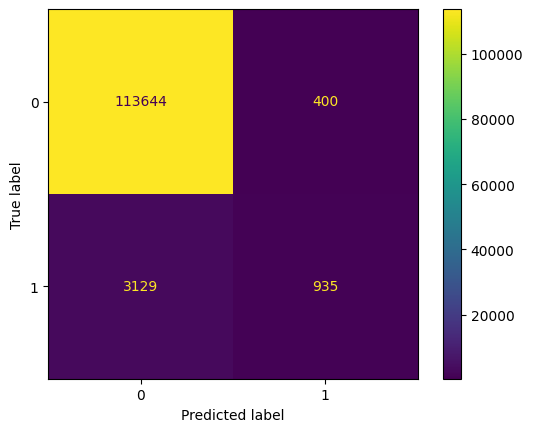

In [32]:
# Confusion Matrix
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [34]:
# Uisng class weights to give more importance to fraud cases

# Initiating the model
dt_model_wt = DecisionTreeClassifier(
    max_depth=8,
    class_weight={0:1, 1:10},  # make fraud cases more important
    random_state=42
)

# Fitting the data into the model
dt_model_wt.fit(X_train, y_train)
print(f'Training Score: {round((dt_model_wt.score(X_train, y_train))*100, 2)} %')


# Test Prediction 
y_pred = dt_model_wt.predict(X_test)


# Metrics
print(f'Testing Score: {round((accuracy_score(y_test, y_pred))*100, 2)} %')
print(f'Precision Score: {round((precision_score(y_test, y_pred, pos_label = 1))*100, 2)} %')
print(f'Recall Score: {round((recall_score(y_test, y_pred, pos_label = 1))*100, 2)} %')

Training Score: 93.72 %
Testing Score: 92.35 %
Precision Score: 22.61 %
Recall Score: 50.47 %


              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    114044
         1.0       0.23      0.50      0.31      4064

    accuracy                           0.92    118108
   macro avg       0.60      0.72      0.64    118108
weighted avg       0.96      0.92      0.94    118108



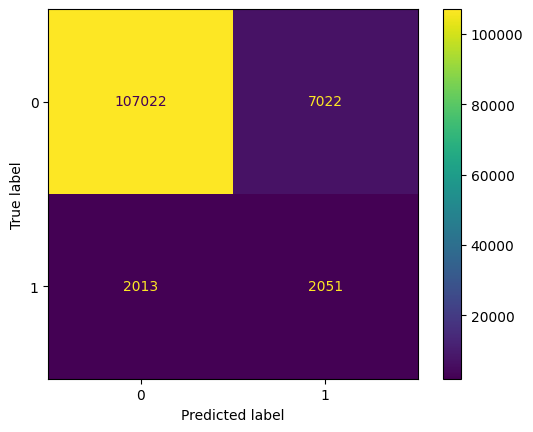

In [35]:
# Confusion Matrix
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [38]:
# Weight tuning loop

for w in [15, 20, 30, 40, 50]:
    model = DecisionTreeClassifier(
        max_depth=8,
        class_weight={0:1, 1:w},
        random_state=42
    )
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_probs = model.predict_proba(X_test)[:,1]
    test_preds = (test_probs > 0.5).astype(int)

    print(
        f"weight={w:>2} | "
        f"train_acc={accuracy_score(y_train, train_preds):.3f} | "
        f"test_acc={accuracy_score(y_test, test_preds):.3f} | "
        f"recall={recall_score(y_test, test_preds):.3f} | "
        f"precision={precision_score(y_test, test_preds):.3f}"
    )

weight=15 | train_acc=0.920 | test_acc=0.907 | recall=0.577 | precision=0.201
weight=20 | train_acc=0.897 | test_acc=0.886 | recall=0.609 | precision=0.172
weight=30 | train_acc=0.840 | test_acc=0.838 | recall=0.696 | precision=0.137
weight=40 | train_acc=0.816 | test_acc=0.821 | recall=0.708 | precision=0.126
weight=50 | train_acc=0.704 | test_acc=0.712 | recall=0.817 | precision=0.091


Weight 30 was selected because it provides the best balance between capturing a high proportion of fraud cases and keeping false positives at an acceptable level while maintaining stable model generalization.

In [1]:
# Experiment tracking
import mlflow
import dagshub

mlflow.set_tracking_uri('https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow')
dagshub.init(repo_owner='ankitshow005', repo_name='fraud-detection-mlops-platform', mlflow=True)

# mlflow.set_experiment("Decision Tree Baseline")
mlflow.set_experiment("Decision Tree Baseline")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

e:\fraud-detection-mlops-platform\finenv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=8a0ff5e0-cde6-4f9b-835f-e323e833adbd&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=8cb63e64c36d81c697a9a8a269616f5101cd06e6fc1446692f102c4bb15238be




Accessing as ankitshow005

Initialized MLflow to track repo "ankitshow005/fraud-detection-mlops-platform"

Repository ankitshow005/fraud-detection-mlops-platform initialized!

2026/01/15 13:14:04 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/59259f93806f4e4db6eff39eeb85b824', creation_time=1768463044875, experiment_id='0', last_update_time=1768463044875, lifecycle_stage='active', name='Decision Tree Baseline', tags={}>

In [9]:
# Configuring logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

WEIGHTS = [15, 20, 30, 40, 50]
THRESHOLD = 0.5

for w in WEIGHTS:

    logging.info(f"Starting experiment for fraud_weight = {w}")

    with mlflow.start_run(run_name=f"fraud_weight_{w}"):
        start_time = time.time()

        # Log experiment parameters
        logging.info("Logging preprocessing parameters...")
        mlflow.log_param("model_type", "DecisionTree")
        mlflow.log_param("max_depth", 8)
        mlflow.log_param("fraud_weight", w)
        mlflow.log_param("threshold", THRESHOLD)

        logging.info("Training model...")
        model = DecisionTreeClassifier(
            max_depth=8,
            class_weight={0:1, 1:w},
            random_state=42
        )
        model.fit(X_train, y_train)

        logging.info("Generating probability scores...")
        probs = model.predict_proba(X_test)[:,1]
        y_pred = (probs > THRESHOLD).astype(int)

        logging.info("Calculating metrics...")
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Log execution time
        end_time = time.time()
        logging.info(f"Model training and logging completed in {end_time - start_time:.2f} seconds.")

        # Log metrics to MLflow
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1", f1)

        logging.info(f"Results | weight={w} | recall={rec:.3f} | precision={prec:.3f}")

        # Log model
        mlflow.sklearn.log_model(model, "fraud_model")

logging.info("All experiments completed.")

2026-01-15 13:18:03,599 | INFO | Starting experiment for fraud_weight = 15
2026-01-15 13:18:05,167 | INFO | Logging preprocessing parameters...
2026-01-15 13:18:06,871 | INFO | Training model...
2026-01-15 13:18:33,399 | INFO | Generating probability scores...
2026-01-15 13:18:33,681 | INFO | Calculating metrics...
2026-01-15 13:18:33,788 | INFO | Model training and logging completed in 28.62 seconds.
2026-01-15 13:18:35,782 | INFO | Results | weight=15 | recall=0.577 | precision=0.201
2026/01/15 13:18:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run fraud_weight_15 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0/runs/8d917083dc04460fa5dae6c17616d05e
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0


2026-01-15 13:18:59,010 | INFO | Starting experiment for fraud_weight = 20
2026-01-15 13:18:59,724 | INFO | Logging preprocessing parameters...
2026-01-15 13:19:01,404 | INFO | Training model...
2026-01-15 13:19:31,529 | INFO | Generating probability scores...
2026-01-15 13:19:32,150 | INFO | Calculating metrics...
2026-01-15 13:19:32,281 | INFO | Model training and logging completed in 32.56 seconds.
2026-01-15 13:19:34,046 | INFO | Results | weight=20 | recall=0.609 | precision=0.172
2026/01/15 13:19:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run fraud_weight_20 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0/runs/bd06b99922ed4fa08645b5145ca72e84
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0


2026-01-15 13:19:51,819 | INFO | Starting experiment for fraud_weight = 30
2026-01-15 13:19:52,240 | INFO | Logging preprocessing parameters...
2026-01-15 13:19:54,008 | INFO | Training model...
2026-01-15 13:20:22,764 | INFO | Generating probability scores...
2026-01-15 13:20:23,133 | INFO | Calculating metrics...
2026-01-15 13:20:23,223 | INFO | Model training and logging completed in 30.98 seconds.
2026-01-15 13:20:25,130 | INFO | Results | weight=30 | recall=0.696 | precision=0.137
2026/01/15 13:20:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run fraud_weight_30 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0/runs/22837dc3de3f4166822f28ab809c14e4
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0


2026-01-15 13:20:41,895 | INFO | Starting experiment for fraud_weight = 40
2026-01-15 13:20:42,340 | INFO | Logging preprocessing parameters...
2026-01-15 13:20:44,160 | INFO | Training model...
2026-01-15 13:21:08,498 | INFO | Generating probability scores...
2026-01-15 13:21:08,870 | INFO | Calculating metrics...
2026-01-15 13:21:08,963 | INFO | Model training and logging completed in 26.62 seconds.
2026-01-15 13:21:10,816 | INFO | Results | weight=40 | recall=0.708 | precision=0.126
2026/01/15 13:21:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run fraud_weight_40 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0/runs/b3bd5249c67b49d38de72007555b866e
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0


2026-01-15 13:21:26,751 | INFO | Starting experiment for fraud_weight = 50
2026-01-15 13:21:27,257 | INFO | Logging preprocessing parameters...
2026-01-15 13:21:29,058 | INFO | Training model...
2026-01-15 13:21:51,475 | INFO | Generating probability scores...
2026-01-15 13:21:51,751 | INFO | Calculating metrics...
2026-01-15 13:21:51,805 | INFO | Model training and logging completed in 24.55 seconds.
2026-01-15 13:21:53,720 | INFO | Results | weight=50 | recall=0.817 | precision=0.091
2026/01/15 13:21:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run fraud_weight_50 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0/runs/129ce5c6df6d44da84387ec6f0423ea4
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/0


2026-01-15 13:22:07,751 | INFO | All experiments completed.


## Using Xgboost

In [13]:
# Configuration
CONFIG = {
    "mlflow_tracking_uri": "https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow",
    "dagshub_repo_owner": "ankitshow005",
    "dagshub_repo_name": "fraud-detection-mlops-platform",
    "experiment_name": "Xgboost Tuning"
}

# ========================== SETUP MLflow & DAGSHUB ==========================
mlflow.set_tracking_uri(CONFIG["mlflow_tracking_uri"])
dagshub.init(repo_owner=CONFIG["dagshub_repo_owner"], repo_name=CONFIG["dagshub_repo_name"], mlflow=True)
mlflow.set_experiment(CONFIG["experiment_name"])

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
logging.info("Starting fraud model hyperparameter search")

# Compute fraud imbalance ratio
fraud_ratio = (y_train == 0).sum() / (y_train == 1).sum()
logging.info(f"Computed scale_pos_weight = {fraud_ratio:.2f}")

# Base XGBoost model
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=fraud_ratio,
    n_jobs=1,
    random_state=42
)

# Hyperparameter space
param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# Randomized search
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring="recall",      # fraud objective
    cv=3,
    verbose=2,
    n_jobs=1
)

# MLflow run
with mlflow.start_run(run_name="XGBoost_RandomSearch_Fraud"):

    logging.info("Running RandomizedSearchCV...")
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    best_params = search.best_params_

    logging.info(f"Best hyperparameters found: {best_params}")

    # Log best hyperparameters
    for k, v in best_params.items():
        mlflow.log_param(k, v)

    # Evaluate on future test data
    logging.info("Evaluating best model on test data...")
    probs = best_model.predict_proba(X_test)[:, 1]

    THRESHOLD = 0.3
    preds = (probs > THRESHOLD).astype(int)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    logging.info(f"Final Test Metrics | Recall={rec:.3f} | Precision={prec:.3f} | Accuracy={acc:.3f}")

    # Log metrics
    mlflow.log_param("threshold", THRESHOLD)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1", f1)

    # Log model
    mlflow.xgboost.log_model(best_model, name="fraud_xgboost_model")
    logging.info("Fraud model successfully logged to MLflow")

logging.info("Hyperparameter search completed")

2026-01-15 14:01:20,574 | INFO | HTTP Request: GET https://dagshub.com/api/v1/repos/ankitshow005/fraud-detection-mlops-platform "HTTP/1.1 200 OK"


Initialized MLflow to track repo "ankitshow005/fraud-detection-mlops-platform"

2026-01-15 14:01:20,587 | INFO | Initialized MLflow to track repo "ankitshow005/fraud-detection-mlops-platform"


Repository ankitshow005/fraud-detection-mlops-platform initialized!

2026-01-15 14:01:20,591 | INFO | Repository ankitshow005/fraud-detection-mlops-platform initialized!
2026-01-15 14:01:26,495 | INFO | Starting fraud model hyperparameter search
2026-01-15 14:01:26,599 | INFO | Computed scale_pos_weight = 27.46
2026-01-15 14:01:27,349 | INFO | Running RandomizedSearchCV...


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.7; total time= 4.2min
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.7; total time= 4.2min
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.7; total time= 4.2min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=400, subsample=1.0; total time= 2.5min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=400, subsample=1.0; total time= 2.5min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=400, subsample=1.0; total time= 2.3min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.8; total time= 1.9min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.8; total time= 1.7min
[CV] END cols

2026-01-15 16:24:04,382 | INFO | Best hyperparameters found: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 1.0}
2026-01-15 16:24:08,018 | INFO | Evaluating best model on test data...
2026-01-15 16:24:09,300 | INFO | Final Test Metrics | Recall=0.885 | Precision=0.081 | Accuracy=0.650
2026-01-15 16:24:37,741 | INFO | Fraud model successfully logged to MLflow


🏃 View run XGBoost_RandomSearch_Fraud at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1/runs/cb2011f7540c4034aeb2d7cf3ce3d218
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1


2026-01-15 16:24:38,620 | INFO | Hyperparameter search completed


In [14]:
# Configuration
CONFIG = {
    "mlflow_tracking_uri": "https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow",
    "dagshub_repo_owner": "ankitshow005",
    "dagshub_repo_name": "fraud-detection-mlops-platform",
    "experiment_name": "Xgboost Tuning"
}

# ========================== SETUP MLflow & DAGSHUB ==========================
mlflow.set_tracking_uri(CONFIG["mlflow_tracking_uri"])
dagshub.init(repo_owner=CONFIG["dagshub_repo_owner"], repo_name=CONFIG["dagshub_repo_name"], mlflow=True)
mlflow.set_experiment(CONFIG["experiment_name"])


THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5]

for t in THRESHOLDS:

    with mlflow.start_run(run_name=f"XGB_threshold_final{t}"):

        logging.info(f"Evaluating threshold = {t}")

        mlflow.log_param("model_type", "XGBoost")
        mlflow.log_param("threshold", t)

        for k, v in best_params.items():
            mlflow.log_param(k, v)

        model = XGBClassifier(
            **best_params,
            objective="binary:logistic",
            eval_metric="logloss",
            scale_pos_weight=fraud_ratio,
            tree_method="hist",
            n_jobs=1,
            random_state=42
        )

        model.fit(X_train, y_train)

        probs = model.predict_proba(X_test)[:,1]
        preds = (probs > t).astype(int)

        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1", f1)

        mlflow.xgboost.log_model(model, name="fraud_xgboost_model")

        logging.info(f"threshold={t} | recall={rec:.3f} | precision={prec:.3f}")

2026-01-15 16:37:25,335 | INFO | HTTP Request: GET https://dagshub.com/api/v1/repos/ankitshow005/fraud-detection-mlops-platform "HTTP/1.1 200 OK"


Initialized MLflow to track repo "ankitshow005/fraud-detection-mlops-platform"

2026-01-15 16:37:25,370 | INFO | Initialized MLflow to track repo "ankitshow005/fraud-detection-mlops-platform"


Repository ankitshow005/fraud-detection-mlops-platform initialized!

2026-01-15 16:37:25,375 | INFO | Repository ankitshow005/fraud-detection-mlops-platform initialized!
2026-01-15 16:37:31,505 | INFO | Evaluating threshold = 0.1
2026-01-15 16:40:11,502 | WARNING | Retrying (Retry(total=6, connect=7, read=6, redirect=7, status=7)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /ankitshow005/fraud-detection-mlops-platform.mlflow/api/2.0/mlflow/runs/log-metric
2026-01-15 16:41:43,835 | WARNING | Retrying (Retry(total=6, connect=7, read=7, redirect=7, status=7)) after connection broken by 'SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2417)')': /ankitshow005/fraud-detection-mlops-platform.mlflow/api/2.0/mlflow-artifacts/artifacts/ef6b8339dc85451b8e77229d4171625e/models/m-017dcb31a49643f8a990eda7801529e9/artifacts/model.ubj
2026-01-15 16:43:54,303 | WARNING | Retrying (Retry(total=5, connect=7, read=7, redirect=7, status=7)) after connection broken by 'SSLEOFError(8, 'EOF occurred in violati

🏃 View run XGB_threshold_final0.1 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1/runs/02aed62ee6e34f07b525660d379ace66
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1


2026-01-15 16:44:53,602 | INFO | Evaluating threshold = 0.2
2026-01-15 16:49:33,971 | INFO | threshold=0.2 | recall=0.954 | precision=0.053


🏃 View run XGB_threshold_final0.2 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1/runs/bf3ef20942e5496f832860f2b862b037
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1


2026-01-15 16:49:35,428 | INFO | Evaluating threshold = 0.3
2026-01-15 16:52:47,099 | INFO | threshold=0.3 | recall=0.885 | precision=0.081


🏃 View run XGB_threshold_final0.3 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1/runs/bd51968862bf44f7a205e9e306f18c41
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1


2026-01-15 16:52:48,731 | INFO | Evaluating threshold = 0.4
2026-01-15 16:55:42,609 | WARNING | Retrying (Retry(total=6, connect=7, read=7, redirect=7, status=7)) after connection broken by 'SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)'))': /ankitshow005/fraud-detection-mlops-platform.mlflow/api/2.0/mlflow/runs/log-metric
2026-01-15 16:56:09,022 | WARNING | Retrying (Retry(total=6, connect=7, read=6, redirect=7, status=7)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /ankitshow005/fraud-detection-mlops-platform.mlflow/api/2.0/mlflow/runs/log-metric
2026-01-15 16:57:29,816 | INFO | threshold=0.4 | recall=0.820 | precision=0.113


🏃 View run XGB_threshold_final0.4 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1/runs/bd486dd3d55e4652881741010b87f85e
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1


2026-01-15 16:57:37,919 | INFO | Evaluating threshold = 0.5
2026-01-15 17:00:17,300 | INFO | threshold=0.5 | recall=0.749 | precision=0.153


🏃 View run XGB_threshold_final0.5 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1/runs/2e722a8d80eb47eb85befe373e7c51a9
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/1


## LightGBM Fraud Model

In [18]:
import logging
import mlflow
import mlflow.lightgbm
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ===================== MLflow (DAGsHub) =====================
mlflow.set_tracking_uri("https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow")
mlflow.set_experiment("Lightgbm model")

# ===================== Logging =====================
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
logging.info("Starting LightGBM Fraud Training")

# ===================== Prepare Data =====================
# Copy only what we need
Xtr = X_train.copy()
Xte = X_test.copy()

# Encode categorical columns (Arrow → integer codes)
cat_cols = Xtr.select_dtypes(include=["category"]).columns.tolist()
logging.info(f"Encoding {len(cat_cols)} categorical columns")

for col in cat_cols:
    Xtr[col] = Xtr[col].cat.codes
    Xte[col] = Xte[col].cat.codes

# Convert everything to float32 for LightGBM
Xtr = Xtr.astype("float32")
Xte = Xte.astype("float32")

# ===================== Class imbalance =====================
fraud_ratio = (y_train == 0).sum() / (y_train == 1).sum()
logging.info(f"Fraud scale_pos_weight = {fraud_ratio:.2f}")

# ===================== LightGBM params =====================
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "min_child_samples": 200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": fraud_ratio,
    "n_jobs": 1,
    "random_state": 42
}

THRESHOLDS = [0.3, 0.4, 0.5]

# ===================== MLflow runs =====================
for t in THRESHOLDS:

    with mlflow.start_run(run_name=f"LightGBM_threshold_{t}"):

        logging.info(f"Training LightGBM with threshold={t}")

        # Log params
        for k, v in params.items():
            mlflow.log_param(k, v)
        mlflow.log_param("threshold", t)

        # Train
        model = lgb.LGBMClassifier(**params)
        model.fit(Xtr, y_train)

        # Predict
        probs = model.predict_proba(Xte)[:, 1]
        preds = (probs > t).astype(int)

        # Metrics
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)

        logging.info(
            f"threshold={t} | recall={rec:.3f} | precision={prec:.3f} | f1={f1:.3f}"
        )

        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1", f1)

        # Log model
        mlflow.lightgbm.log_model(model, name="fraud_lightgbm_model")

logging.info("LightGBM experiments completed successfully")

2026-01-15 19:03:30,977 | INFO | Starting LightGBM Fraud Training
2026-01-15 19:03:37,224 | INFO | Encoding 0 categorical columns
2026-01-15 19:03:38,784 | INFO | Fraud scale_pos_weight = 27.46
2026-01-15 19:03:39,436 | INFO | Training LightGBM with threshold=0.3


[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.377583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33308
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 430
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784


2026-01-15 19:04:35,926 | INFO | threshold=0.3 | recall=0.877 | precision=0.110 | f1=0.196


🏃 View run LightGBM_threshold_0.3 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/2/runs/df7691a8fd2842389e84443475b2ac7f
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/2


2026-01-15 19:05:41,057 | INFO | Training LightGBM with threshold=0.4


[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.139203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33308
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 430
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784


2026-01-15 19:06:33,468 | INFO | threshold=0.4 | recall=0.824 | precision=0.146 | f1=0.248


🏃 View run LightGBM_threshold_0.4 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/2/runs/17663019c5d34821bb96525f65faa561
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/2


2026-01-15 19:07:17,823 | INFO | Training LightGBM with threshold=0.5


[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.247104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33308
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 430
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784


2026-01-15 19:08:13,807 | INFO | threshold=0.5 | recall=0.760 | precision=0.186 | f1=0.299


🏃 View run LightGBM_threshold_0.5 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/2/runs/4272e9e09db44c2bb538f0742cdc6e94
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/2


2026-01-15 19:08:39,940 | INFO | LightGBM experiments completed successfully


## Catboost Model

In [19]:
import logging
import mlflow
import mlflow.catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ===================== MLflow (DAGsHub) =====================
mlflow.set_tracking_uri("https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow")
mlflow.set_experiment("CatBoost Model")

# ===================== Logging =====================
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
logging.info("Starting CatBoost Fraud Training")

# ===================== Prepare Data =====================
# Copy only what CatBoost needs
Xtr = X_train.copy()
Xte = X_test.copy()

# Convert everything to float32 (CatBoost works best with NumPy)
Xtr = Xtr.astype("float32")
Xte = Xte.astype("float32")

# ===================== Class imbalance =====================
fraud_ratio = (y_train == 0).sum() / (y_train == 1).sum()
logging.info(f"Fraud scale_pos_weight = {fraud_ratio:.2f}")

# ===================== CatBoost parameters =====================
params = {
    "iterations": 400,
    "depth": 8,
    "learning_rate": 0.05,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",
    "scale_pos_weight": fraud_ratio,
    "verbose": False,
    "random_seed": 42
}

THRESHOLDS = [0.3, 0.4, 0.5]

# ===================== MLflow runs =====================
for t in THRESHOLDS:

    with mlflow.start_run(run_name=f"CatBoost_threshold_{t}"):

        logging.info(f"Training CatBoost with threshold={t}")

        # Log params
        for k, v in params.items():
            mlflow.log_param(k, v)
        mlflow.log_param("threshold", t)

        # Train
        model = CatBoostClassifier(**params)
        model.fit(Xtr, y_train)

        # Predict
        probs = model.predict_proba(Xte)[:, 1]
        preds = (probs > t).astype(int)

        # Metrics
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)

        logging.info(
            f"threshold={t} | recall={rec:.3f} | precision={prec:.3f} | f1={f1:.3f}"
        )

        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1", f1)

        # Log model
        mlflow.catboost.log_model(model, name="fraud_catboost_model")

logging.info("CatBoost fraud experiments completed")

2026/01/15 19:28:28 INFO mlflow.tracking.fluent: Experiment with name 'CatBoost Model' does not exist. Creating a new experiment.
2026-01-15 19:28:31,168 | INFO | Starting CatBoost Fraud Training
2026-01-15 19:28:39,731 | INFO | Fraud scale_pos_weight = 27.46
2026-01-15 19:28:40,397 | INFO | Training CatBoost with threshold=0.3
2026-01-15 19:38:59,242 | INFO | threshold=0.3 | recall=0.858 | precision=0.124 | f1=0.217


🏃 View run CatBoost_threshold_0.3 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/3/runs/a9692d50862646da868641f5c71190f0
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/3


2026-01-15 19:39:24,059 | INFO | Training CatBoost with threshold=0.4
2026-01-15 19:45:47,445 | INFO | threshold=0.4 | recall=0.787 | precision=0.166 | f1=0.274
2026-01-15 19:46:56,795 | WARNING | Retrying (Retry(total=6, connect=7, read=7, redirect=7, status=7)) after connection broken by 'SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2417)')': /ankitshow005/fraud-detection-mlops-platform.mlflow/api/2.0/mlflow-artifacts/artifacts/7bd2ba8dcff14edbbd7472542ea9c04a/models/m-f650b8b928a0480ebe464f83dd649e67/artifacts/model.cb


🏃 View run CatBoost_threshold_0.4 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/3/runs/2380baa05f654b599b7702c05434cb9f
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/3


2026-01-15 19:48:13,635 | INFO | Training CatBoost with threshold=0.5
2026-01-15 19:53:30,173 | INFO | threshold=0.5 | recall=0.722 | precision=0.217 | f1=0.334


🏃 View run CatBoost_threshold_0.5 at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/3/runs/838f2d19b5564b4184a1eef1bf38809c
🧪 View experiment at: https://dagshub.com/ankitshow005/fraud-detection-mlops-platform.mlflow/#/experiments/3


2026-01-15 19:53:53,321 | INFO | CatBoost fraud experiments completed


## Final Obs


LightGBM delivered the best balance of recall and precision, making it the strongest single production model.

CatBoost achieved the highest precision, making it ideal for reducing false positives in manual review workflows.

XGBoost captured the most fraud cases but generated more false alerts, so it is best for high-risk screening layers.

Threshold tuning proved critical because it allowed control over the fraud vs customer friction trade-off.

Time-based splitting ensured the model was evaluated in a realistic, production-like scenario.

Arrow and Parquet enabled memory-efficient storage and fast loading of large fraud datasets.

MLflow with DAGsHub provided full experiment tracking, reproducibility, and model comparison.

Combining LightGBM for recall and CatBoost for precision can create a hybrid fraud engine used in real fintech systems.

In [33]:
# Retrain LightGBM (using our best parameters)

import lightgbm as lgb
import pandas as pd

# Your best LightGBM params
lgb_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "min_child_samples": 200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": 27.46147358274595,
    "n_jobs": 1,
    "random_state": 42
}

# IMPORTANT: LightGBM requires pure numeric numpy/pandas dtypes
Xtr = X_train.astype("float32")
Xte = X_test.astype("float32")

# Train
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(Xtr, y_train)

[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.116370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33308
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 430
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,200


In [27]:
# Get feature importance

importances = lgb_model.feature_importances_
features = X_train.columns

fi = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

fi["importance_pct"] = fi["importance"] / fi["importance"].sum()
fi["cumulative_importance"] = fi["importance_pct"].cumsum()

fi.head(10)

,feature,importance,importance_pct,cumulative_importance
3,card1,385,0.061111,0.061111
4,card2,337,0.053492,0.114603
27,C13,295,0.046825,0.161429
9,addr1,226,0.035873,0.197302
1,TransactionAmt,221,0.035079,0.232381
0,TransactionDT,212,0.033651,0.266032
29,D1,203,0.032222,0.298254
15,C1,192,0.030476,0.328730
28,C14,180,0.028571,0.357302
43,D15,176,0.027937,0.385238


In [22]:
# Finding how many features explain most fraud signal

top90 = fi[fi["cumulative_importance"] <= 0.90]

print("Features needed for 90% of fraud signal:", len(top90))

Features needed for 90% of fraud signal: 99


In [28]:
# Getting the top 100 features explaining more than 90% fraud signals

TOP_N = 100
prod_features = fi["feature"].iloc[:TOP_N].tolist()

In [29]:
# Retrain LightGBM (using our best parameters) with top 100 features

# Using our best LightGBM params
lgb_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "min_child_samples": 200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": 27.46147358274595,
    "n_jobs": 1,
    "random_state": 42
}

# IMPORTANT: LightGBM requires pure numeric numpy/pandas dtypes
X_train_prod = X_train[prod_features].astype("float32")
X_test_prod  = X_test[prod_features].astype("float32")

# Train
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_prod, y_train)


# Use PROBABILITIES not predict()
probs = lgb_model.predict_proba(X_test_prod)[:, 1]

# Use the threshold selected earlier
THRESHOLD = 0.4   # <-- from your MLflow tuning
y_pred = (probs > THRESHOLD).astype(int)


# Metrics
print(f'Training Score: {round((lgb_model.score(X_train_prod, y_train))*100, 2)} %')
print(f'Testing Score: {round((accuracy_score(y_test, y_pred))*100, 2)} %')
print(f'Precision Score: {round((precision_score(y_test, y_pred, pos_label = 1))*100, 2)} %')
print(f'Recall Score: {round((recall_score(y_test, y_pred, pos_label = 1))*100, 2)} %')

[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11984
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035135 -> initscore=-3.312784
[LightGBM] [Info] Start training from score -3.312784
Training Score: 89.44 %
Testing Score: 83.02 %
Precision Score: 14.62 %
Recall Score: 81.25 %


              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90    114044
         1.0       0.15      0.81      0.25      4064

    accuracy                           0.83    118108
   macro avg       0.57      0.82      0.58    118108
weighted avg       0.96      0.83      0.88    118108



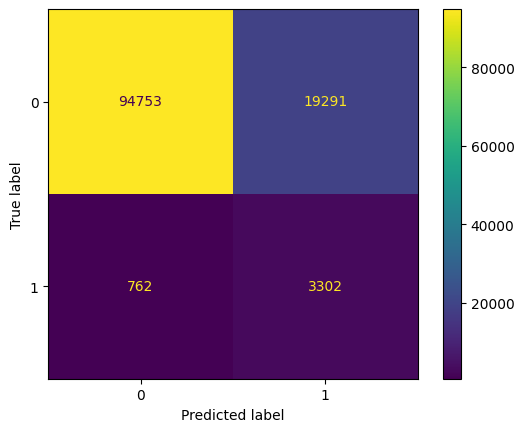

In [30]:
# Confusion Matrix
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))